In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
import copy
from sklearn.metrics import classification_report

In [31]:
import warnings
warnings.filterwarnings('ignore')

# Pre-process

In [34]:
def preprocess(df:  pd.DataFrame) -> pd.DataFrame:
    X = df.drop(['id', 'Status'], axis=1)
    y = df[['Status']]

    # One-hot encoding
    X_1h = pd.get_dummies(X,
                          columns=['Drug', 'Sex', 'Ascites',
                                   'Hepatomegaly', 'Spiders', 'Edema'],
                          dtype=np.uint8)
    X_1h.drop(['Drug_D-penicillamine', 'Sex_M', 'Ascites_N',
              'Hepatomegaly_N', 'Spiders_N'], axis=1, inplace=True)

    # Standard Scaler
    X_encoded = X_1h[['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                      'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']]
    X_std = X_1h.drop(['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                       'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'], axis=1)

    std_scaler = StandardScaler()
    std_scaled_data = std_scaler.fit_transform(X_std)
    X_std = pd.DataFrame(
        std_scaled_data, index=X_std.index, columns=X_std.columns)

    processed_df = pd.concat([X_std, X_encoded, y], axis=1)

    return processed_df

In [35]:
def preprocess_X(X_df:  pd.DataFrame) -> pd.DataFrame:
    X = X_df.drop(['id'], axis=1)

    # One-hot encoding
    X_1h = pd.get_dummies(X,
                          columns=['Drug', 'Sex', 'Ascites',
                                   'Hepatomegaly', 'Spiders', 'Edema'],
                          dtype=np.uint8)
    X_1h.drop(['Drug_D-penicillamine', 'Sex_M', 'Ascites_N',
              'Hepatomegaly_N', 'Spiders_N'], axis=1, inplace=True)

    # Standard Scaler
    X_encoded = X_1h[['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                      'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']]
    X_std = X_1h.drop(['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                       'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'], axis=1)

    std_scaler = StandardScaler()
    std_scaled_data = std_scaler.fit_transform(X_std)
    X_std = pd.DataFrame(
        std_scaled_data, index=X_std.index, columns=X_std.columns)

    processed_X_df = pd.concat([X_std, X_encoded], axis=1)

    return processed_X_df

## One-hot Encoding Target

In [36]:
train_df = pd.read_csv('./data/train_ds_processed.csv')

In [37]:
X = train_df.drop(['Status'], axis=1)
y = train_df[['Status']]

In [38]:
onehot_enc = OneHotEncoder(sparse_output=False).fit(y)
onehot_enc.categories_

[array(['C', 'CL', 'D'], dtype=object)]

In [39]:
y = onehot_enc.transform(y)

# Model Planning

In [57]:
LEARNING_RATE = 0.0002
N_EPOCHS = 100
BATCH_SIZE = 20

In [41]:
# Multiclass-classifier with only Linear layers
class MulticlassLO(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 10)
        self.output = nn.Linear(10, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return torch.softmax(x, dim=1)

In [61]:
model = MulticlassLO()

In [62]:
loss_fn = nn.CrossEntropyLoss()

In [63]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Data Preparation

In [44]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([6324, 20])
torch.Size([6324, 3])


In [45]:
# split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, shuffle=True)

In [51]:
batches_per_epoch = len(X_train) // BATCH_SIZE

# Model Training

In [64]:
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = []

In [65]:
for epoch in range(N_EPOCHS):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * BATCH_SIZE
            X_batch = X_train[start:start+BATCH_SIZE]
            y_batch = y_train[start:start+BATCH_SIZE]
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()
            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    
    # Set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_valid)
    ce = loss_fn(y_pred, y_valid)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_valid, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    valid_loss_hist.append(ce)
    valid_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0: 100%|██████████| 221/221 [00:01<00:00, 142.06batch/s, acc=0.8, loss=0.907] 


Epoch 0 validation: Cross-entropy=0.96, Accuracy=68.6%


Epoch 1: 100%|██████████| 221/221 [00:01<00:00, 143.23batch/s, acc=1, loss=0.68]    


Epoch 1 validation: Cross-entropy=0.81, Accuracy=77.9%


Epoch 2: 100%|██████████| 221/221 [00:01<00:00, 146.04batch/s, acc=1, loss=0.615]   


Epoch 2 validation: Cross-entropy=0.78, Accuracy=78.2%


Epoch 3: 100%|██████████| 221/221 [00:01<00:00, 155.60batch/s, acc=1, loss=0.593]   


Epoch 3 validation: Cross-entropy=0.77, Accuracy=78.9%


Epoch 4: 100%|██████████| 221/221 [00:01<00:00, 149.30batch/s, acc=1, loss=0.583]   


Epoch 4 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 5: 100%|██████████| 221/221 [00:01<00:00, 150.53batch/s, acc=1, loss=0.577]   


Epoch 5 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 6: 100%|██████████| 221/221 [00:01<00:00, 145.50batch/s, acc=1, loss=0.574]   


Epoch 6 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 7: 100%|██████████| 221/221 [00:01<00:00, 149.46batch/s, acc=1, loss=0.573]   


Epoch 7 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 8: 100%|██████████| 221/221 [00:01<00:00, 130.47batch/s, acc=1, loss=0.572]   


Epoch 8 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 9: 100%|██████████| 221/221 [00:01<00:00, 132.76batch/s, acc=1, loss=0.571]   


Epoch 9 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 10: 100%|██████████| 221/221 [00:03<00:00, 64.11batch/s, acc=1, loss=0.571]    


Epoch 10 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 11: 100%|██████████| 221/221 [00:03<00:00, 65.73batch/s, acc=1, loss=0.571]    


Epoch 11 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 12: 100%|██████████| 221/221 [00:02<00:00, 85.10batch/s, acc=1, loss=0.572]    


Epoch 12 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 13: 100%|██████████| 221/221 [00:01<00:00, 127.36batch/s, acc=1, loss=0.572]   


Epoch 13 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 14: 100%|██████████| 221/221 [00:01<00:00, 133.35batch/s, acc=1, loss=0.573]   


Epoch 14 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 15: 100%|██████████| 221/221 [00:01<00:00, 114.16batch/s, acc=1, loss=0.574]   


Epoch 15 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 16: 100%|██████████| 221/221 [00:01<00:00, 113.36batch/s, acc=1, loss=0.574]   


Epoch 16 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 17: 100%|██████████| 221/221 [00:02<00:00, 106.33batch/s, acc=1, loss=0.575]   


Epoch 17 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 18: 100%|██████████| 221/221 [00:02<00:00, 84.93batch/s, acc=1, loss=0.576]    


Epoch 18 validation: Cross-entropy=0.76, Accuracy=78.6%


Epoch 19: 100%|██████████| 221/221 [00:02<00:00, 98.41batch/s, acc=1, loss=0.576]    


Epoch 19 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 20: 100%|██████████| 221/221 [00:04<00:00, 44.24batch/s, acc=1, loss=0.577]    


Epoch 20 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 21: 100%|██████████| 221/221 [00:08<00:00, 25.30batch/s, acc=1, loss=0.577]    


Epoch 21 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 22: 100%|██████████| 221/221 [00:02<00:00, 107.00batch/s, acc=1, loss=0.578]   


Epoch 22 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 23: 100%|██████████| 221/221 [00:01<00:00, 111.92batch/s, acc=1, loss=0.578]   


Epoch 23 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 24: 100%|██████████| 221/221 [00:02<00:00, 93.32batch/s, acc=1, loss=0.578]    


Epoch 24 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 25: 100%|██████████| 221/221 [00:03<00:00, 56.91batch/s, acc=1, loss=0.578]    


Epoch 25 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 26: 100%|██████████| 221/221 [00:03<00:00, 63.64batch/s, acc=1, loss=0.578]    


Epoch 26 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 27: 100%|██████████| 221/221 [00:01<00:00, 119.33batch/s, acc=1, loss=0.578]   


Epoch 27 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 28: 100%|██████████| 221/221 [00:02<00:00, 110.26batch/s, acc=1, loss=0.578]   


Epoch 28 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 29: 100%|██████████| 221/221 [00:02<00:00, 73.73batch/s, acc=1, loss=0.578]    


Epoch 29 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 30: 100%|██████████| 221/221 [00:04<00:00, 51.53batch/s, acc=1, loss=0.578]    


Epoch 30 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 31: 100%|██████████| 221/221 [00:02<00:00, 93.02batch/s, acc=1, loss=0.578]    


Epoch 31 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 32: 100%|██████████| 221/221 [00:03<00:00, 66.85batch/s, acc=1, loss=0.578]    


Epoch 32 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 33: 100%|██████████| 221/221 [00:01<00:00, 111.70batch/s, acc=1, loss=0.578]   


Epoch 33 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 34: 100%|██████████| 221/221 [00:01<00:00, 116.09batch/s, acc=1, loss=0.578]   


Epoch 34 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 35: 100%|██████████| 221/221 [00:01<00:00, 130.72batch/s, acc=1, loss=0.578]   


Epoch 35 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 36: 100%|██████████| 221/221 [00:01<00:00, 120.12batch/s, acc=1, loss=0.578]   


Epoch 36 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 37: 100%|██████████| 221/221 [00:02<00:00, 101.77batch/s, acc=1, loss=0.578]   


Epoch 37 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 38: 100%|██████████| 221/221 [00:01<00:00, 114.98batch/s, acc=1, loss=0.578]   


Epoch 38 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 39: 100%|██████████| 221/221 [00:02<00:00, 95.56batch/s, acc=1, loss=0.578]    


Epoch 39 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 40: 100%|██████████| 221/221 [00:01<00:00, 116.14batch/s, acc=1, loss=0.578]   


Epoch 40 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 41: 100%|██████████| 221/221 [00:02<00:00, 80.81batch/s, acc=1, loss=0.578]    


Epoch 41 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 42: 100%|██████████| 221/221 [00:01<00:00, 111.80batch/s, acc=1, loss=0.578]   


Epoch 42 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 43: 100%|██████████| 221/221 [00:02<00:00, 107.46batch/s, acc=1, loss=0.578]   


Epoch 43 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 44: 100%|██████████| 221/221 [00:01<00:00, 128.28batch/s, acc=1, loss=0.578]   


Epoch 44 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 45: 100%|██████████| 221/221 [00:01<00:00, 115.20batch/s, acc=1, loss=0.579]   


Epoch 45 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 46: 100%|██████████| 221/221 [00:01<00:00, 131.51batch/s, acc=1, loss=0.579]   


Epoch 46 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 47: 100%|██████████| 221/221 [00:01<00:00, 135.43batch/s, acc=1, loss=0.579]   


Epoch 47 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 48: 100%|██████████| 221/221 [00:01<00:00, 133.22batch/s, acc=1, loss=0.579]   


Epoch 48 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 49: 100%|██████████| 221/221 [00:01<00:00, 141.93batch/s, acc=1, loss=0.579]   


Epoch 49 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 50: 100%|██████████| 221/221 [00:01<00:00, 124.99batch/s, acc=1, loss=0.579]   


Epoch 50 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 51: 100%|██████████| 221/221 [00:01<00:00, 130.75batch/s, acc=1, loss=0.579]   


Epoch 51 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 52: 100%|██████████| 221/221 [00:01<00:00, 133.86batch/s, acc=1, loss=0.579]   


Epoch 52 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 53: 100%|██████████| 221/221 [00:01<00:00, 118.84batch/s, acc=1, loss=0.579]   


Epoch 53 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 54: 100%|██████████| 221/221 [00:01<00:00, 139.62batch/s, acc=0.95, loss=0.58] 


Epoch 54 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 55: 100%|██████████| 221/221 [00:01<00:00, 116.91batch/s, acc=0.95, loss=0.58] 


Epoch 55 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 56: 100%|██████████| 221/221 [00:01<00:00, 122.04batch/s, acc=0.95, loss=0.58] 


Epoch 56 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 57: 100%|██████████| 221/221 [00:01<00:00, 134.27batch/s, acc=0.95, loss=0.58] 


Epoch 57 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 58: 100%|██████████| 221/221 [00:01<00:00, 134.06batch/s, acc=0.95, loss=0.58] 


Epoch 58 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 59: 100%|██████████| 221/221 [00:01<00:00, 127.81batch/s, acc=0.95, loss=0.581]


Epoch 59 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 60: 100%|██████████| 221/221 [00:01<00:00, 131.34batch/s, acc=0.95, loss=0.581]


Epoch 60 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 61: 100%|██████████| 221/221 [00:01<00:00, 127.44batch/s, acc=0.95, loss=0.581]


Epoch 61 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 62: 100%|██████████| 221/221 [00:01<00:00, 127.15batch/s, acc=0.95, loss=0.582]


Epoch 62 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 63: 100%|██████████| 221/221 [00:01<00:00, 114.69batch/s, acc=0.95, loss=0.582]


Epoch 63 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 64: 100%|██████████| 221/221 [00:01<00:00, 115.78batch/s, acc=0.95, loss=0.582]


Epoch 64 validation: Cross-entropy=0.76, Accuracy=79.1%


Epoch 65: 100%|██████████| 221/221 [00:01<00:00, 131.84batch/s, acc=0.95, loss=0.583]


Epoch 65 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 66: 100%|██████████| 221/221 [00:02<00:00, 102.76batch/s, acc=0.95, loss=0.583]


Epoch 66 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 67: 100%|██████████| 221/221 [00:01<00:00, 131.50batch/s, acc=0.95, loss=0.583]


Epoch 67 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 68: 100%|██████████| 221/221 [00:01<00:00, 124.23batch/s, acc=0.95, loss=0.583]


Epoch 68 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 69: 100%|██████████| 221/221 [00:01<00:00, 127.85batch/s, acc=0.95, loss=0.584]


Epoch 69 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 70: 100%|██████████| 221/221 [00:01<00:00, 135.50batch/s, acc=0.95, loss=0.584]


Epoch 70 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 71: 100%|██████████| 221/221 [00:01<00:00, 122.14batch/s, acc=0.95, loss=0.584]


Epoch 71 validation: Cross-entropy=0.76, Accuracy=79.0%


Epoch 72: 100%|██████████| 221/221 [00:01<00:00, 128.09batch/s, acc=0.95, loss=0.584]


Epoch 72 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 73: 100%|██████████| 221/221 [00:01<00:00, 136.72batch/s, acc=0.95, loss=0.585]


Epoch 73 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 74: 100%|██████████| 221/221 [00:01<00:00, 127.55batch/s, acc=0.95, loss=0.585]


Epoch 74 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 75: 100%|██████████| 221/221 [00:01<00:00, 133.58batch/s, acc=0.95, loss=0.585]


Epoch 75 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 76: 100%|██████████| 221/221 [00:01<00:00, 141.00batch/s, acc=0.95, loss=0.586]


Epoch 76 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 77: 100%|██████████| 221/221 [00:01<00:00, 128.14batch/s, acc=0.95, loss=0.586]


Epoch 77 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 78: 100%|██████████| 221/221 [00:01<00:00, 124.66batch/s, acc=0.95, loss=0.586]


Epoch 78 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 79: 100%|██████████| 221/221 [00:01<00:00, 139.16batch/s, acc=0.95, loss=0.586]


Epoch 79 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 80: 100%|██████████| 221/221 [00:01<00:00, 127.70batch/s, acc=0.95, loss=0.586]


Epoch 80 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 81: 100%|██████████| 221/221 [00:01<00:00, 138.07batch/s, acc=0.95, loss=0.587]


Epoch 81 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 82: 100%|██████████| 221/221 [00:01<00:00, 127.95batch/s, acc=0.95, loss=0.587]


Epoch 82 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 83: 100%|██████████| 221/221 [00:01<00:00, 128.25batch/s, acc=0.95, loss=0.587]


Epoch 83 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 84: 100%|██████████| 221/221 [00:01<00:00, 133.23batch/s, acc=0.95, loss=0.587]


Epoch 84 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 85: 100%|██████████| 221/221 [00:01<00:00, 138.81batch/s, acc=0.95, loss=0.587]


Epoch 85 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 86: 100%|██████████| 221/221 [00:01<00:00, 130.42batch/s, acc=0.95, loss=0.587]


Epoch 86 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 87: 100%|██████████| 221/221 [00:01<00:00, 117.42batch/s, acc=0.95, loss=0.587]


Epoch 87 validation: Cross-entropy=0.76, Accuracy=78.9%


Epoch 88: 100%|██████████| 221/221 [00:01<00:00, 119.44batch/s, acc=0.95, loss=0.587]


Epoch 88 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 89: 100%|██████████| 221/221 [00:02<00:00, 101.84batch/s, acc=0.95, loss=0.587]


Epoch 89 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 90: 100%|██████████| 221/221 [00:01<00:00, 122.25batch/s, acc=0.95, loss=0.587]


Epoch 90 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 91: 100%|██████████| 221/221 [00:01<00:00, 122.26batch/s, acc=0.95, loss=0.587]


Epoch 91 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 92: 100%|██████████| 221/221 [00:01<00:00, 118.29batch/s, acc=0.95, loss=0.587]


Epoch 92 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 93: 100%|██████████| 221/221 [00:01<00:00, 135.29batch/s, acc=0.95, loss=0.587]


Epoch 93 validation: Cross-entropy=0.76, Accuracy=78.8%


Epoch 94: 100%|██████████| 221/221 [00:01<00:00, 121.91batch/s, acc=0.95, loss=0.586]


Epoch 94 validation: Cross-entropy=0.76, Accuracy=78.7%


Epoch 95: 100%|██████████| 221/221 [00:02<00:00, 93.39batch/s, acc=0.95, loss=0.586] 


Epoch 95 validation: Cross-entropy=0.76, Accuracy=78.6%


Epoch 96: 100%|██████████| 221/221 [00:02<00:00, 103.80batch/s, acc=0.95, loss=0.586]


Epoch 96 validation: Cross-entropy=0.76, Accuracy=78.6%


Epoch 97: 100%|██████████| 221/221 [00:01<00:00, 135.66batch/s, acc=0.95, loss=0.586]


Epoch 97 validation: Cross-entropy=0.76, Accuracy=78.6%


Epoch 98: 100%|██████████| 221/221 [00:02<00:00, 75.78batch/s, acc=0.95, loss=0.586] 


Epoch 98 validation: Cross-entropy=0.76, Accuracy=78.6%


Epoch 99: 100%|██████████| 221/221 [00:02<00:00, 86.74batch/s, acc=0.95, loss=0.586] 

Epoch 99 validation: Cross-entropy=0.76, Accuracy=78.6%


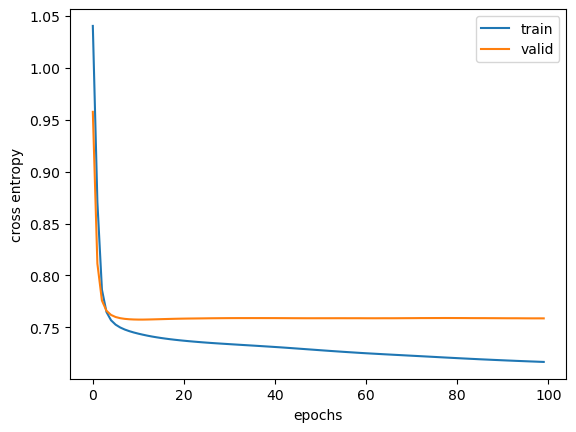

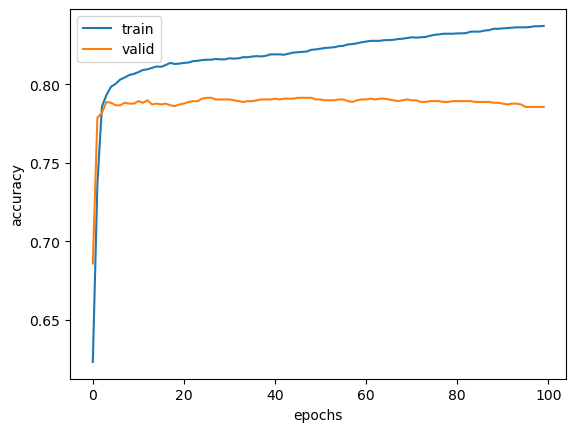

In [66]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(valid_loss_hist, label="valid")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(valid_acc_hist, label="valid")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [67]:
# Restore best model
model.load_state_dict(best_weights)

# Evaluate best model
model.eval()
y_pred = model(X_valid)
ce = loss_fn(y_pred, y_valid)
acc = (torch.argmax(y_pred, 1) == torch.argmax(y_valid, 1)).float().mean()

ce = float(ce)
acc = float(acc)
print(f"Valid (training) Dataset: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Valid (training) Dataset: Cross-entropy=0.76, Accuracy=79.1%


In [68]:
print(classification_report(torch.argmax(y_valid, 1), torch.argmax(y_pred, 1), target_names=['C', 'CL', 'D']))

              precision    recall  f1-score   support

           C       0.82      0.89      0.85      1214
          CL       0.00      0.00      0.00        64
           D       0.72      0.69      0.71       620

    accuracy                           0.79      1898
   macro avg       0.52      0.52      0.52      1898
weighted avg       0.76      0.79      0.78      1898



## Save Model

In [100]:
# Restore best model
model.load_state_dict(best_weights)

torch.save(model.state_dict(), './models/multiclass_lo.pth')

# Test Model

In [7]:
test_df = pd.read_csv('./data/test_ds.csv')
test_df = preprocess(test_df)
test_df.head(5)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Stage,Drug_Placebo,Sex_F,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_N,Edema_S,Edema_Y,Status
0,1.867719,-0.995874,-0.501778,-0.673743,0.132320,-0.680346,-0.583609,-0.982508,-0.164250,1.984845,...,2.0,0,1,0,0,0,1,0,0,C
1,-0.298014,-0.881071,-0.447462,1.454269,-1.770508,-0.641761,0.002771,1.126982,0.093545,-0.352261,...,3.0,0,1,0,0,0,1,0,0,C
2,0.439912,-0.611379,-0.556094,-1.270488,0.160720,-0.435979,-0.523194,-0.100930,-1.235090,-1.761234,...,3.0,1,1,0,0,1,1,0,0,C
3,1.158801,0.523017,-0.556094,-0.268408,0.274322,-0.616039,-0.594778,-0.888053,-0.580688,0.005573,...,3.0,0,1,0,0,0,1,0,0,C
4,0.252258,0.517018,-0.447462,-0.690632,-0.208485,-0.474563,-0.503394,-1.013993,-1.016956,-1.202118,...,4.0,0,1,0,1,0,1,0,0,D


In [15]:
X_test = test_df.drop(['Status'], axis=1)
y_test = test_df[['Status']]

In [16]:
# Encode Target
onehot_enc_test = OneHotEncoder(sparse_output=False).fit(y_test)
print(onehot_enc_test.categories_)
y_test = onehot_enc_test.transform(y_test)

[array(['C', 'CL', 'D'], dtype=object)]


In [17]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape)
print(y_test.shape)

torch.Size([1581, 20])
torch.Size([1581, 3])


In [20]:
# Load the model
model = MulticlassLO()
model.load_state_dict(torch.load('./models/multiclass_lo.pth'))

<All keys matched successfully>

In [29]:
model.eval()
y_pred = model(X_test)
ce = loss_fn(y_pred, y_test)
acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()

ce = float(ce)
acc = float(acc)
print(f"Test (training) Dataset: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Test (training) Dataset: Cross-entropy=0.74, Accuracy=80.9%


In [33]:
print(classification_report(torch.argmax(y_test, 1), torch.argmax(y_pred, 1), target_names=['C', 'CL', 'D']))

              precision    recall  f1-score   support

           C       0.84      0.90      0.87       993
          CL       0.00      0.00      0.00        55
           D       0.75      0.72      0.73       533

    accuracy                           0.81      1581
   macro avg       0.53      0.54      0.53      1581
weighted avg       0.78      0.81      0.79      1581



# Prediction on the Test Dataset
_The non-labelled official test dataset from Kaggle_

In [6]:
kaggle_test_df = pd.read_csv('./data/test.csv')
kaggle_test_df.head(5)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [7]:
X_kaggle_test = preprocess_X(kaggle_test_df)
X_kaggle_test

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_F,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.656608,0.342186,-0.363546,0.965540,-0.473636,-0.254101,-0.090552,0.782524,-0.480744,1.895231,-0.041463,2.0,0,1,0,1,0,1,0,0
1,0.395038,-0.983033,-0.389506,1.534346,1.921728,0.119925,-0.286401,0.782524,0.755049,-0.422762,-0.798430,2.0,0,1,0,0,0,1,0,0
2,-1.829045,-1.492582,-0.155863,-1.005321,-1.629046,-0.499153,-0.439359,-0.895372,-0.271610,-0.582624,2.986409,4.0,1,1,0,1,0,0,0,1
3,0.268052,0.561521,-0.519308,-0.296809,0.879041,-0.576538,-0.649677,0.244331,-1.127159,0.068241,-0.041463,2.0,0,1,0,0,0,1,0,0
4,-0.389878,0.950520,-0.311625,-0.376641,-1.600866,0.468156,-0.362363,0.233097,0.203695,-0.491274,-1.050753,1.0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.764951,-1.735358,-0.337585,-0.251903,-0.304551,-0.125127,-0.240927,0.641593,-1.355306,-0.948022,-0.041463,3.0,1,1,0,0,0,1,0,0
5267,-0.247250,1.759492,-0.545268,-0.666034,1.555379,0.468156,-0.593351,-0.705421,-0.404696,0.536407,-1.176914,3.0,1,1,0,0,0,1,0,0
5268,1.535144,-0.420743,-0.467387,-0.187039,1.555379,-0.924769,-0.090035,1.162425,-0.860989,1.849556,0.337021,3.0,0,1,0,1,0,1,0,0
5269,-0.757031,-1.876558,-0.493347,-0.117186,0.738137,-0.421768,-0.585599,-1.155788,0.203695,0.479314,-0.546108,1.0,1,1,0,0,0,1,0,0


In [8]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_kaggle_test = torch.tensor(X_kaggle_test.values, dtype=torch.float32)

In [11]:
# # Load model
# model = MulticlassLO()
# model.load_state_dict(torch.load('./models/multiclass_lo.pth'))

<All keys matched successfully>

In [12]:
model.eval()
y_kaggle_pred = model(X_kaggle_test)
y_kaggle_pred

tensor([[9.8632e-01, 4.7884e-04, 1.3203e-02],
        [9.8302e-01, 8.6955e-04, 1.6112e-02],
        [1.5635e-02, 4.3543e-05, 9.8432e-01],
        ...,
        [9.9901e-01, 2.0583e-05, 9.6896e-04],
        [9.9918e-01, 4.1421e-05, 7.7788e-04],
        [1.4819e-01, 2.2790e-03, 8.4953e-01]], grad_fn=<SoftmaxBackward0>)

## Finalize the result

In [17]:
def finalize_result(y_pred, id_col, columns_name) -> pd.DataFrame:

    y_pred.detach().apply_(lambda x: max(min(x, 1 - 10**(-15)), 10**(-15)))
    res_df = pd.DataFrame(y_pred.detach().numpy(), dtype=np.float32, columns=columns_name)

    res_df = pd.concat([id_col, res_df], axis=1)
    return res_df
    

In [15]:
col_names = ['Status_C', 'Status_CL', 'Status_D']

In [20]:
res_df = finalize_result(y_kaggle_pred, kaggle_test_df[['id']], columns_name=col_names)
res_df

,id,Status_C,Status_CL,Status_D
0,7905,0.986318,0.000479,0.013203
1,7906,0.983019,0.000870,0.016112
2,7907,0.015635,0.000044,0.984321
3,7908,0.998028,0.000132,0.001841
4,7909,0.814857,0.003046,0.182098
...,...,...,...,...
5266,13171,0.997255,0.000045,0.002700
5267,13172,0.999258,0.000028,0.000714
5268,13173,0.999010,0.000021,0.000969
5269,13174,0.999181,0.000041,0.000778


## Save the result to .csv file

In [124]:
res_df.to_csv('./results/multiclass_lo_res.csv', index=False)